### Описание задания.

Решить задачу классификации вина на основе датасета [Wine Quality](https://www.kaggle.com/datasets/rajyellow46/wine-quality). Целевой признак quality.

Проект оформить в соответствии с CRISP-DM подходом.

### 1. Business Undestanding.

#### 1.1 Цель

Предсказать к какой категории качества относится вино.

#### 1.2 Описание

Представлен датасет с физико-химическими свойствами для разных вариантов красного и белого португальского вина «Vinho Verde». Целевой признак описывает, к какой из категорий было относено вино. Категории представлены числами от 0 до 10.

Классы упорядочены и не сбалансированы: нормальных вин намного больше, чем отличных или плохих.

На основе физико-химических свойств вина предсказать к какой категории качества относится вино.

### 2. Data Understanding

#### 2.1 Импорт библиотек

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

# Modelling Helpers
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import StandardScaler

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 8, 6

#### 2.2 Вспомогательные функции

In [2]:
def plot_histograms(df, variables, n_rows, n_cols):
    fig = plt.figure(figsize=(16, 12))
    for ind, var_name in enumerate(variables):
        ax = fig.add_subplot(n_rows, n_cols, ind+1)
        df[ var_name ].hist(bins=10, ax=ax)
        ax.set_title('Skew: ' + str(round(float(df[var_name].skew()), )))
        ax.set_xticklabels([], visible=False)
        ax.set_yticklabels([], visible=False)
    fig.tight_layout()
    plt.show()

def plot_distribution(df, var, target, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    offset = (df[var].max() - df[var].min()) * 0.1
    xleft = kwargs.get('xleft', df[var].min() - offset )
    xright = kwargs.get('xright', df[var].max() + offset )
    facet = sns.FacetGrid(df, hue=target , aspect=4 , row=row, col=col)
    facet.map(sns.kdeplot, var, shade=True)
    facet.set(xlim=(xleft, xright))
    facet.set_ylabels(label=None)
    facet.fig.suptitle(f'Взаимосвязь между {var} и {target}')
    facet.add_legend()

def plot_categories(df, cat, target, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, row = row, col = col)
    facet.map(sns.barplot, cat, target)
    facet.add_legend()

def plot_correlation_map(df):
    corr = df.corr()
    _ , ax = plt.subplots(figsize=(12, 10))
    cmap = 'coolwarm'
    _ = sns.heatmap(
        corr, 
        cmap=cmap,
        square=True, 
        cbar_kws={'shrink':.9}, 
        ax=ax, 
        annot=True, 
        annot_kws={'fontsize':12}
    )

def describe_more(df):
    var, level, _type = [], [], []
    for val in df:
        var.append(val)
        level.append(len(pd.value_counts(df[val])))
        _type.append(df[val].dtypes)
    levels = pd.DataFrame({'Variable':var, 'Levels':level, 'Datatype':_type})
    levels.sort_values(by='Levels', inplace=True)
    return levels

def plot_variable_importance(X_val, y_val):
    tree = DecisionTreeClassifier(random_state=21)
    tree.fit(X_val, y_val)
    plot_model_var_imp(tree, X_val, y_val)

def plot_model_var_imp(model, X_val, y_val, index):
    imp = pd.DataFrame( 
        model.feature_importances_, 
        columns=['Importance'], 
        index=index 
    )
    imp = imp.sort_values(['Importance'], ascending=True)
    imp[:10].plot(kind='barh')
    print(model.score(X_val, y_val))

#### 2.3 Загрузка данных

In [3]:
wines = pd.read_csv('../data/external/winequalityN.csv')
wines.shape

(6497, 13)

#### 2.4 Статистика и визуализация

In [4]:
wines.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


**Описание признаков**
- type: тип вина
- fixed acidity: фиксированная кислотность
- volatile acidity: летучая кислотность
- citric acid: лимонная кислота
- residual sugar: остаточный сахар
- chlorides: хлориды
- free sulfur dioxide: свободный диоксид серы
- total sulfur dioxide: общий диоксид серы 
- density: плотность
- pH: водородный показатель
- sulphates: сульфаты
- alcohol: алкоголь

Целевой признак (на основе сенсорных данных):
- quality: категория качества от 0 до 10

#### 2.4.1 Ключевая информацию о признаках.

Признаки type и quality являются категориальными, остальные признаки - числовыми.

In [5]:
wines.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [6]:
wines['quality'].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

Наблюдается, что в датесете преобладают вина категории 5, 6 и 7. Вина категории 4 и 8 представлены в меньшем количестве. Вино категорий 3 и 9 совсем мало. А категорий 1, 2 и 10 совсем отсутствуют.

#### 2.4.2 Тепловая карта корреляции может дать нам понимание того, какие признаки важны

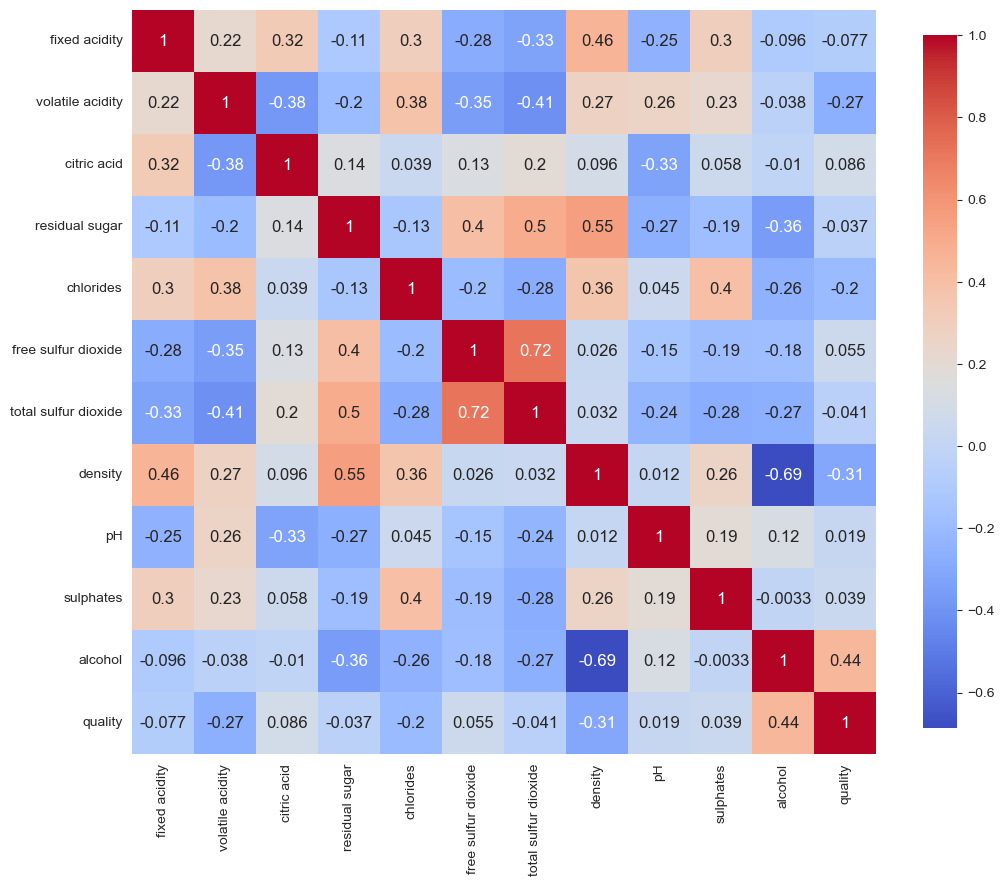

In [7]:
plot_correlation_map(wines)

#### 2.4.3 Взаимосвязь между целевого признака с наиболее коллерируемыми с ней признаками.

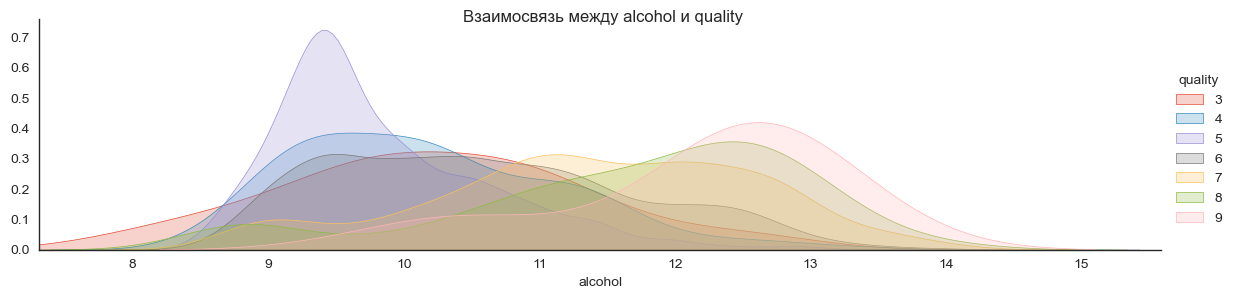

In [8]:
plot_distribution(wines, var='alcohol', target='quality')

На графике можно увидеть, что вина высокой категории 7, 8 и 9 имеют более высокие показатели по алкоголю в сравнению с винами более низкой категории 3, 4 и 5. Однако, четкого разделения нет и одни распределения перекрывают другие.

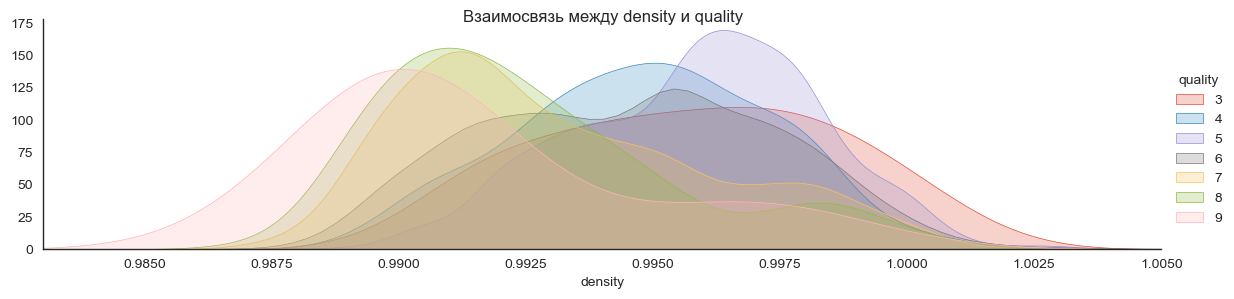

In [9]:
plot_distribution(wines, var='density', target='quality', xleft = 0.983, xright = 1.005)

На графике можно увидеть, обратную корреляцию признаков: вина высокой категории 7, 8 и 9 имеют более низкие показатели плотности по сравнению с винами более низкой категории 3, 4 и 5. Четкого разделения между распределениями опять же нет.

### 3. Data Preparation

#### 3.1 Преобразование категориальных признаков в числовые.

In [10]:
data = wines.copy()

In [11]:
data['type'] = data['type'].apply(lambda val: 0 if val == 'white' else 1)

#### 3.2 Устранение пропущенных значений

In [12]:
data.isna().sum().sum()

38

In [13]:
data[wines['quality'].isin([3, 9])].isna().sum().sum()

0

In [14]:
data[data['quality'].isin([4, 8])].isna().sum().sum()

3

Самые малопредставленные категории не содержат пропуски, а категории с относительно небольшим количеством записей не содержат критического количества пропущенных значений, поэтому принимаем решение удалить записи с пропусками.

In [15]:
data.dropna(axis=0, inplace=True)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6463 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6463 non-null   int64  
 1   fixed acidity         6463 non-null   float64
 2   volatile acidity      6463 non-null   float64
 3   citric acid           6463 non-null   float64
 4   residual sugar        6463 non-null   float64
 5   chlorides             6463 non-null   float64
 6   free sulfur dioxide   6463 non-null   float64
 7   total sulfur dioxide  6463 non-null   float64
 8   density               6463 non-null   float64
 9   pH                    6463 non-null   float64
 10  sulphates             6463 non-null   float64
 11  alcohol               6463 non-null   float64
 12  quality               6463 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 706.9 KB


### 3.3 Feature Engineering

In [17]:
data.corr()[['quality']].sort_values(by='quality', ascending = False)

,quality
quality,1.000000
alcohol,0.444637
citric acid,0.084926
free sulfur dioxide,0.054924
sulphates,0.039054
pH,0.018403
residual sugar,-0.034654
total sulfur dioxide,-0.041598
fixed acidity,-0.076174
type,-0.119185


По графику корреляции наблюдается большая корреляция между признаками:
    
- free sulfur dioxide и total sulfur dioxide = 0,72;
- density и alcohol = -0,69

Исключим из каждой пары по одному признаку с наименьшим влияние на целевой признак: total sulfur dioxide и density

In [18]:
data.drop(columns=['total sulfur dioxide', 'density'], inplace=True)

In [19]:
data.to_csv('../data/intermid/wines_intermid.csv', index=False)

### 3.4 Сборка финальных датасетов для моделирования

#### 3.4.1 Variable selection

In [20]:
X = data.drop(columns=['quality'])
y = data['quality']

#### 3.4.2 Нормализация

In [21]:
scaler = StandardScaler()
X_scal = pd.DataFrame(scaler.fit_transform(X), index=X.index)

#### 3.4.3 Создание датасетов

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_scal, y, test_size = 0.2, random_state=21, stratify=y)

### 4. Моделирование

В качестве отправной точки для последующего сравнение результатов работы моделей произведём обучение KNeighborsClassifier.

In [23]:
model = KNeighborsClassifier()

In [24]:
model.fit(X_train, y_train)

KNeighborsClassifier()

Оценка точности модели, на тестовых данных, где мы знаем фактический результат. 
Затем мы сравниваем точность с точностью при использовании модели на тренировочных данных. Если разница между ними значительна, это свидетельствует о переобучении. Мы стараемся избегать этого, потому что это означает, что модель не будет хорошо обобщаться на новые данные (будет работать плохо)

In [25]:
pred = model.predict(X_test)
score = classification_report(y_test, pred, zero_division=0)
print(score)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.23      0.12      0.15        43
           5       0.58      0.69      0.63       426
           6       0.59      0.60      0.59       564
           7       0.52      0.42      0.47       215
           8       0.33      0.11      0.16        38
           9       0.00      0.00      0.00         1

    accuracy                           0.57      1293
   macro avg       0.32      0.28      0.29      1293
weighted avg       0.55      0.57      0.55      1293



In [26]:
confusion_matrix(y_test, pred)

array([[  0,   2,   3,   1,   0,   0,   0],
       [  0,   5,  20,  17,   1,   0,   0],
       [  0,   7, 294, 117,   8,   0,   0],
       [  1,   7, 157, 339,  55,   5,   0],
       [  0,   1,  29,  91,  91,   3,   0],
       [  0,   0,   2,  14,  18,   4,   0],
       [  0,   0,   0,   0,   1,   0,   0]], dtype=int64)

Качество модели получилось очень низкое, поэтому обучим другую модель, чтобы увеличить качество предсказания целевого признака.

### 5. Обучение новой модели

Применим стеккинг из трёх моделей.

In [27]:
model = StackingClassifier([
    ('DecisionTreeClassifier', DecisionTreeClassifier()), 
    ('RandomForestClassifier', RandomForestClassifier(
        criterion='entropy',
        max_depth=10,
        min_samples_leaf= 1,
        n_estimators=100,
        random_state=21)),
    ('SVR', LinearSVC(random_state=21))
    ], final_estimator=LogisticRegression(solver='lbfgs', max_iter=10000))

In [28]:
model.fit(X_train, y_train)

StackingClassifier(estimators=[('DecisionTreeClassifier',
                                DecisionTreeClassifier()),
                               ('RandomForestClassifier',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=10,
                                                       random_state=21)),
                               ('SVR', LinearSVC(random_state=21))],
                   final_estimator=LogisticRegression(max_iter=10000))

### 6. Avaluation

#### 6.1 Оценка модели

In [29]:
pred = model.predict(X_test)
score = classification_report(y_test, pred, zero_division=0)
print(score)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.57      0.19      0.28        43
           5       0.72      0.70      0.71       426
           6       0.64      0.76      0.70       564
           7       0.66      0.51      0.58       215
           8       0.74      0.45      0.56        38
           9       0.00      0.00      0.00         1

    accuracy                           0.67      1293
   macro avg       0.48      0.37      0.40      1293
weighted avg       0.67      0.67      0.66      1293



In [30]:
confusion_matrix(y_test, pred)

array([[  0,   2,   2,   2,   0,   0,   0],
       [  0,   8,  21,  13,   1,   0,   0],
       [  0,   3, 299, 122,   2,   0,   0],
       [  0,   1,  90, 430,  42,   1,   0],
       [  0,   0,   6,  94, 110,   5,   0],
       [  0,   0,   0,  10,  11,  17,   0],
       [  0,   0,   0,   0,   1,   0,   0]], dtype=int64)

#### 6.2 Ретроспектива процесса

Применение стеккинга моделей позволило существенно поднять accuracy c 0.57 до 0.67, но всё равно, она остаётся недостаточно хорошей.
Это объясняется тем, что категории качества 3 и 9, как уже отмечалось ранее, содержат крохотное количество записей по сравнению с другими категориями.

#### 6.3 Дальнейшие шаги по улучшению модели.

Возможный вариант устранения данной проблемы видится в применение методов перебалансировки данных: принять количество записей для категории 7 как эталонное, для 5 и 6 категорий применить метод Undersampling по отношению к 7, а для оставшихся категорий применить Oversampling, также по отношению к 7. Это должно устанить несбалансированность классов.

### 7. Deployment

Развертывание в данном случае означает публикацию полученного прогноза.

In [32]:
deploy = wines.iloc[X_test.index]
deploy['quality_pred'] = pred
deploy.to_csv('../reports/wine_pred.csv', index=False)
deploy.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_pred
2396,white,8.4,0.30,0.25,17.75,0.047,25.0,218.0,1.00016,2.98,0.66,9.1,5,5
4458,white,6.6,0.35,0.26,2.70,0.045,19.0,129.0,0.98952,3.24,0.48,13.0,7,6
3095,white,9.7,0.24,0.49,4.90,0.032,3.0,18.0,0.99368,2.85,0.54,10.0,6,6
1018,white,7.1,0.18,0.42,1.40,0.045,47.0,157.0,0.99160,2.95,0.31,10.5,6,6
6355,red,7.6,0.49,0.33,1.90,0.074,27.0,85.0,0.99706,3.41,0.58,9.0,5,5
